In [1]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

In [2]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('../../dataset/HBAN.csv')
df1=df.reset_index()['Close']

In [3]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [4]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [5]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [6]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [7]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [8]:
# 8. Define CNN-LSTM Model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
# Define the model architecture
model = Sequential()

# Add the CNN layers
model.add(Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(100, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Add the LSTM layer
model.add(LSTM(units=64, return_sequences=True,activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=64,activation='relu'))

# Add the dense layers
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

In [9]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
36/36 [==============================] - 4s 38ms/step - loss: 0.0626 - val_loss: 0.0174
Epoch 2/100
36/36 [==============================] - 1s 28ms/step - loss: 0.0100 - val_loss: 0.0180
Epoch 3/100
36/36 [==============================] - 1s 29ms/step - loss: 0.0082 - val_loss: 0.0166
Epoch 4/100
36/36 [==============================] - 1s 28ms/step - loss: 0.0074 - val_loss: 0.0147
Epoch 5/100
36/36 [==============================] - 1s 31ms/step - loss: 0.0061 - val_loss: 0.0140
Epoch 6/100
36/36 [==============================] - 1s 32ms/step - loss: 0.0057 - val_loss: 0.0160
Epoch 7/100
36/36 [==============================] - 1s 34ms/step - loss: 0.0057 - val_loss: 0.0130
Epoch 8/100
36/36 [==============================] - 1s 36ms/step - loss: 0.0055 - val_loss: 0.0141
Epoch 9/100
36/36 [==============================] - 1s 36ms/step - loss: 0.0057 - val_loss: 0.0141
Epoch 10/100
36/36 [==============================] - 1s 37ms/step - loss: 0.0055 - val_loss: 0.0126

In [10]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

8/8 [==============================] - 0s 6ms/step


In [11]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [12]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
yval = scaler.inverse_transform(yval.reshape(-1,1))

In [13]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 1.2580495545635237
Testing RMSE: 1.3362692493422212


In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=277
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps ,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


0 day input [0.73261654 0.70896062 0.7039427  0.70967747 0.6788531  0.6867384
 0.70322586 0.73261654 0.71182801 0.69319001 0.67956994 0.67526887
 0.6523298  0.65949826 0.67168464 0.66164879 0.70179217 0.68172048
 0.67598571 0.6695341  0.70465955 0.69820794 0.71397855 0.72616493
 0.73476708 0.73118285 0.71039432 0.72544808 0.71039432 0.71827962
 0.72186385 0.70537639 0.67383517 0.62867388 0.61505381 0.61362012
 0.63512549 0.58494628 0.59211474 0.60501796 0.60860219 0.59211474
 0.63297496 0.62293911 0.6164875  0.61362012 0.59856635 0.60358427
 0.60573481 0.60573481 0.62365596 0.61577065 0.61720435 0.62078857
 0.60573481 0.58853051 0.63297496 0.63799288 0.67096779 0.66523302
 0.69247317 0.6695341  0.68745525 0.65949826 0.67455202 0.67096779
 0.68888894 0.69319001 0.68315417 0.6960574  0.69103948 0.70035847
 0.70107532 0.70967747 0.73691762 0.75340507 0.76487461 0.76559145
 0.77347676 0.76344091 0.76344091 0.74551977 0.71899647 0.71971331
 0.72114701 0.74050185 0.71397855 0.70179217 0.6960

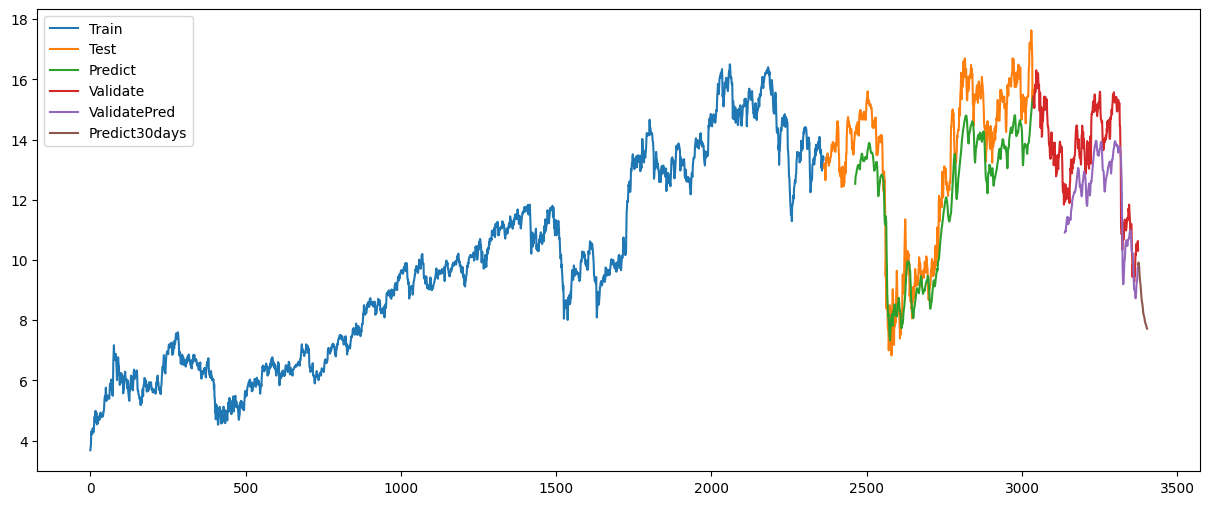

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.subplots(figsize=(15, 6))
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [16]:
scaler.inverse_transform(lst_output)

array([[9.84470765],
       [9.9144397 ],
       [9.90714716],
       [9.82428139],
       [9.64605763],
       [9.44376197],
       [9.32855352],
       [9.23429059],
       [9.15146016],
       [8.99933545],
       [8.85977698],
       [8.72775591],
       [8.63245321],
       [8.58282771],
       [8.50695306],
       [8.4154041 ],
       [8.30087996],
       [8.21626059],
       [8.16903143],
       [8.14120787],
       [8.09523217],
       [8.0196211 ],
       [7.95192744],
       [7.91481744],
       [7.88811597],
       [7.85828189],
       [7.81599714],
       [7.77991778],
       [7.74488358],
       [7.71803078]])